2. Implement classifier-free guidance in your existing DDPM (Denoising Diffusion Probabilistic Model) code. Modify the diffusion sampling process to combine conditional and unconditional predictions for improved sample quality. Document your findings of the differences made in the code. (10 Points)

In [ ]:
!pip install torch torchvision einops tqdm matplotlib --quiet

Device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 20.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 474kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.53MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.7MB/s]
Epoch 1/30: 100%|██████████| 468/468 [00:14<00:00, 32.53it/s]


Epoch 1 | Loss: 0.2370


Epoch 2/30: 100%|██████████| 468/468 [00:12<00:00, 37.95it/s]


Epoch 2 | Loss: 0.0568


Epoch 3/30: 100%|██████████| 468/468 [00:12<00:00, 37.66it/s]


Epoch 3 | Loss: 0.0432


Epoch 4/30: 100%|██████████| 468/468 [00:12<00:00, 37.29it/s]


Epoch 4 | Loss: 0.0388


Epoch 5/30: 100%|██████████| 468/468 [00:12<00:00, 37.03it/s]


Epoch 5 | Loss: 0.0353


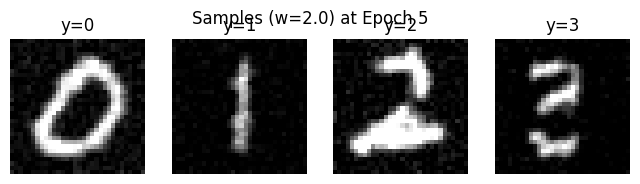

Epoch 6/30: 100%|██████████| 468/468 [00:12<00:00, 37.22it/s]


Epoch 6 | Loss: 0.0321


Epoch 7/30: 100%|██████████| 468/468 [00:12<00:00, 37.19it/s]


Epoch 7 | Loss: 0.0301


Epoch 8/30: 100%|██████████| 468/468 [00:12<00:00, 37.23it/s]


Epoch 8 | Loss: 0.0278


Epoch 9/30: 100%|██████████| 468/468 [00:12<00:00, 37.28it/s]


Epoch 9 | Loss: 0.0263


Epoch 10/30: 100%|██████████| 468/468 [00:12<00:00, 37.36it/s]


Epoch 10 | Loss: 0.0256


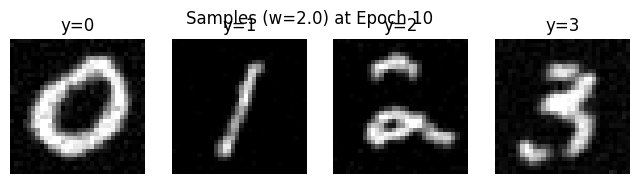

Epoch 11/30: 100%|██████████| 468/468 [00:12<00:00, 37.33it/s]


Epoch 11 | Loss: 0.0242


Epoch 12/30: 100%|██████████| 468/468 [00:12<00:00, 36.92it/s]


Epoch 12 | Loss: 0.0234


Epoch 13/30: 100%|██████████| 468/468 [00:12<00:00, 37.07it/s]


Epoch 13 | Loss: 0.0230


Epoch 14/30: 100%|██████████| 468/468 [00:12<00:00, 37.34it/s]


Epoch 14 | Loss: 0.0223


Epoch 15/30: 100%|██████████| 468/468 [00:12<00:00, 37.48it/s]


Epoch 15 | Loss: 0.0221


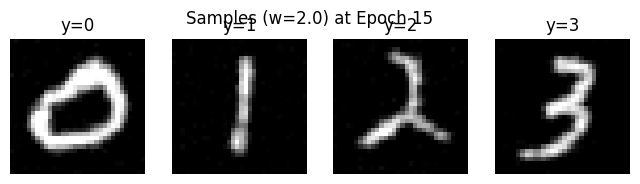

Epoch 16/30: 100%|██████████| 468/468 [00:12<00:00, 37.55it/s]


Epoch 16 | Loss: 0.0219


Epoch 17/30: 100%|██████████| 468/468 [00:12<00:00, 37.16it/s]


Epoch 17 | Loss: 0.0215


Epoch 18/30: 100%|██████████| 468/468 [00:12<00:00, 37.14it/s]


Epoch 18 | Loss: 0.0210


Epoch 19/30: 100%|██████████| 468/468 [00:12<00:00, 37.34it/s]


Epoch 19 | Loss: 0.0208


Epoch 20/30: 100%|██████████| 468/468 [00:12<00:00, 37.35it/s]


Epoch 20 | Loss: 0.0203


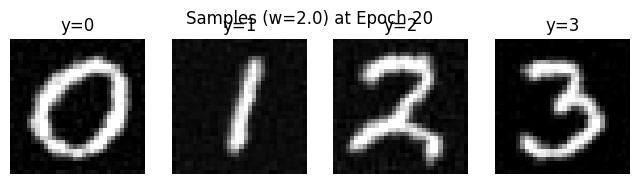

Epoch 21/30: 100%|██████████| 468/468 [00:12<00:00, 36.22it/s]


Epoch 21 | Loss: 0.0201


Epoch 22/30: 100%|██████████| 468/468 [00:12<00:00, 37.13it/s]


Epoch 22 | Loss: 0.0199


Epoch 23/30: 100%|██████████| 468/468 [00:12<00:00, 37.15it/s]


Epoch 23 | Loss: 0.0199


Epoch 24/30: 100%|██████████| 468/468 [00:12<00:00, 37.20it/s]


Epoch 24 | Loss: 0.0199


Epoch 25/30: 100%|██████████| 468/468 [00:12<00:00, 37.29it/s]


Epoch 25 | Loss: 0.0199


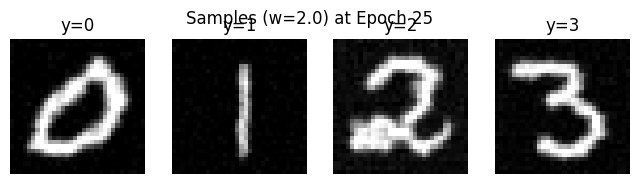

Epoch 26/30: 100%|██████████| 468/468 [00:12<00:00, 37.41it/s]


Epoch 26 | Loss: 0.0197


Epoch 27/30: 100%|██████████| 468/468 [00:12<00:00, 37.20it/s]


Epoch 27 | Loss: 0.0193


Epoch 28/30: 100%|██████████| 468/468 [00:12<00:00, 36.99it/s]


Epoch 28 | Loss: 0.0192


Epoch 29/30: 100%|██████████| 468/468 [00:12<00:00, 37.23it/s]


Epoch 29 | Loss: 0.0189


Epoch 30/30: 100%|██████████| 468/468 [00:12<00:00, 37.41it/s]


Epoch 30 | Loss: 0.0191


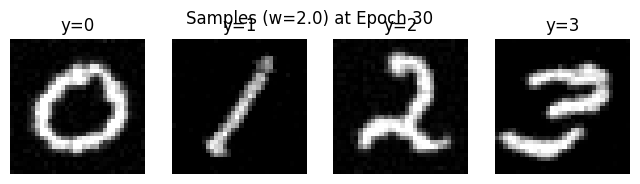

Training complete. Saved: ddpm_mnist_cfg.pt


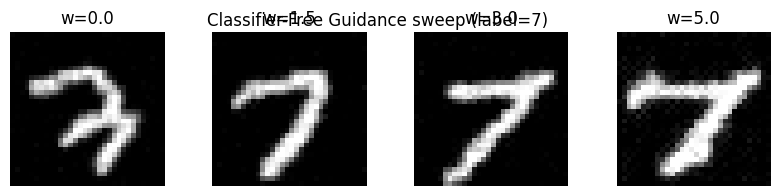

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import numpy as np

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


# Sinusoidal positional embedding

class SinusoidalEmbeddings(nn.Module):

    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    def forward(self, t: torch.Tensor) -> torch.Tensor:

        half = self.dim // 2
        freqs = torch.exp(
            torch.arange(half, device=t.device) * -(math.log(10000.0) / (half - 1))
        )
        args = t[:, None].float() * freqs[None, :]
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        return emb



# Residual block w/ time & cond

class ResBlock(nn.Module):

    def __init__(self, in_ch, out_ch, cond_dim, dropout=0.1):
        super().__init__()

        def valid_groups(ch):

            for g in reversed(range(1, 33)):
                if ch % g == 0:
                    return g
            return 1

        g1, g2 = valid_groups(in_ch), valid_groups(out_ch)

        self.norm1 = nn.GroupNorm(g1, in_ch)
        self.act1  = nn.SiLU()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)

        self.norm2 = nn.GroupNorm(g2, out_ch)
        self.act2  = nn.SiLU()
        self.drop  = nn.Dropout(dropout)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)


        self.emb_proj = nn.Linear(cond_dim, out_ch)


        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, emb):
        h = self.conv1(self.act1(self.norm1(x)))
        h = h + self.emb_proj(emb)[:, :, None, None]
        h = self.conv2(self.drop(self.act2(self.norm2(h))))
        return h + self.skip(x)



# Self-Attention 2D

class SelfAttention(nn.Module):

    def __init__(self, ch):
        super().__init__()
        self.norm = nn.GroupNorm(32 if ch % 32 == 0 else 1, ch)
        self.q = nn.Conv2d(ch, ch, 1)
        self.k = nn.Conv2d(ch, ch, 1)
        self.v = nn.Conv2d(ch, ch, 1)
        self.proj = nn.Conv2d(ch, ch, 1)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.norm(x)
        q = self.q(h).reshape(B, C, H * W).transpose(1, 2)
        k = self.k(h).reshape(B, C, H * W)
        v = self.v(h).reshape(B, C, H * W)
        attn = torch.softmax((q @ k) / math.sqrt(C), dim=-1)
        out = (v @ attn.transpose(1, 2)).reshape(B, C, H, W)
        return x + self.proj(out)



# U-Net with CFG capability

class UNet(nn.Module):

    def __init__(
        self,
        img_ch=1,
        base_ch=64,
        time_emb_dim=256,
        num_classes=10,
        p_uncond=0.2,
    ):
        super().__init__()
        self.num_classes = num_classes
        self.null_class  = num_classes
        self.p_uncond    = p_uncond

        # time embedding MLP
        self.time_mlp = nn.Sequential(
            SinusoidalEmbeddings(time_emb_dim // 4),
            nn.Linear(time_emb_dim // 4, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        # label embedding (+1 for null token)
        self.label_embed = nn.Embedding(num_classes + 1, time_emb_dim)

        cond_dim = time_emb_dim

        # encoder
        self.inc   = ResBlock(img_ch,       base_ch,     cond_dim)
        self.down1 = ResBlock(base_ch,      base_ch * 2, cond_dim)
        self.down2 = ResBlock(base_ch * 2,  base_ch * 4, cond_dim)

        self.downsample = nn.AvgPool2d(2)

        # bottleneck attention at 16x16 (for 32x32 inputs)
        self.attn = SelfAttention(base_ch * 4)

        # decoder
        self.up1 = ResBlock(base_ch * 4, base_ch * 2, cond_dim)
        self.up2 = ResBlock(base_ch * 2, base_ch,     cond_dim)
        self.upsample = nn.Upsample(scale_factor=2, mode="nearest")

        self.outc = nn.Conv2d(base_ch, img_ch, 1)

    def forward(self, x, t, y):

        # build combined embedding = time_emb + label_emb
        t_emb = self.time_mlp(t)
        y_emb = self.label_embed(y)
        emb   = t_emb + y_emb

        # U-Net forward with skip connections
        x1 = self.inc(x, emb)
        x2 = self.down1(self.downsample(x1), emb)
        x3 = self.down2(self.downsample(x2), emb)

        h  = self.attn(x3)
        h  = self.upsample(self.up1(h, emb))

        # skip connection from encoder (same spatial size)
        h  = self.upsample(self.up2(h + x2, emb))

        out = self.outc(h + x1)                 # predict ε
        return out



# DDPM Scheduler

class DDPM_Scheduler:

    def __init__(self, timesteps=1000):
        self.T = timesteps
        self.beta = torch.linspace(1e-4, 0.02, timesteps)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)



# Forward diffusion q(x_t | x_0) sampling

def forward_diffusion(x0, t, scheduler: DDPM_Scheduler):
    # ensure scheduler on correct device
    alpha_bar = scheduler.alpha_bar.to(x0.device)  # (T,)
    a_bar = alpha_bar[t][:, None, None, None]      # (B,1,1,1)
    noise = torch.randn_like(x0)
    x_t = torch.sqrt(a_bar) * x0 + torch.sqrt(1.0 - a_bar) * noise
    return x_t, noise



# CFG sampling: combine conditional & unconditional epŝ

@torch.no_grad()
def sample_cfg(model: UNet,
               scheduler: DDPM_Scheduler,
               labels: torch.Tensor,
               img_size=32,
               guidance_scale=2.0):

    model.eval()
    B = labels.size(0)
    labels = labels.to(device)

    # unconditional labels use the null token
    y_uncond = torch.full_like(labels, fill_value=model.null_class, device=device)

    # pre-move scheduler buffers
    beta      = scheduler.beta.to(device)
    alpha     = scheduler.alpha.to(device)
    alpha_bar = scheduler.alpha_bar.to(device)

    # start from Gaussian noise
    x = torch.randn(B, 1, img_size, img_size, device=device)

    for t in reversed(range(scheduler.T)):
        t_batch = torch.full((B,), t, device=device, dtype=torch.long)

        # predict eps with condition (labels) and without (null)
        eps_cond   = model(x, t_batch, labels)
        eps_uncond = model(x, t_batch, y_uncond)

        # classifier-free guidance mixing
        w  = guidance_scale
        eps = (1 + w) * eps_cond - w * eps_uncond

        # DDPM ancestral update
        beta_t      = beta[t]
        alpha_t     = alpha[t]
        alpha_bar_t = alpha_bar[t]

        if t > 0:
            z = torch.randn_like(x)
        else:
            z = 0.0

        x = (1.0 / torch.sqrt(alpha_t)) * (
                x - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * eps
            ) + torch.sqrt(beta_t) * z

    return x.clamp(0, 1)



# Training routine

def train_ddpm_cfg(
    epochs=20,
    batch_size=128,
    lr=2e-4,
    T=1000,
    p_uncond=0.2,   # probability to drop labels during training
):

    tfm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(32)
    ])
    ds = datasets.MNIST(root="./data", train=True, download=True, transform=tfm)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2, pin_memory=True)

    model = UNet(img_ch=1, base_ch=64, time_emb_dim=256, num_classes=10, p_uncond=p_uncond).to(device)
    sched = DDPM_Scheduler(timesteps=T)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)
    lossf = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        running = 0.0

        for x, y in tqdm(dl, desc=f"Epoch {epoch+1}/{epochs}"):
            x = x.to(device)
            y = y.to(device).long()

            # random unconditional dropout (classifier-free training)

            drop_mask = (torch.rand_like(y.float()) < p_uncond)
            y_train = torch.where(drop_mask, torch.full_like(y, model.null_class), y)

            # sample timesteps
            t = torch.randint(0, sched.T, (x.size(0),), device=device).long()

            # forward diffusion
            x_t, noise = forward_diffusion(x, t, sched)

            # predict noise
            eps_hat = model(x_t, t, y_train)

            loss = lossf(eps_hat, noise)

            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()

            running += loss.item()

        avg = running / len(dl)
        print(f"Epoch {epoch+1} | Loss: {avg:.4f}")

        # quick visual every few epochs
        if (epoch + 1) % 5 == 0:
            model.eval()
            # sample a small batch with fixed labels
            labels = torch.tensor([0, 1, 2, 3], device=device)
            imgs = sample_cfg(model, sched, labels=labels, img_size=32, guidance_scale=2.0)
            plt.figure(figsize=(8, 2))
            for i in range(imgs.size(0)):
                plt.subplot(1, 4, i + 1)
                plt.imshow(imgs[i].detach().cpu().squeeze(), cmap="gray")
                plt.title(f"y={int(labels[i].item())}")
                plt.axis("off")
            plt.suptitle(f"Samples (w=2.0) at Epoch {epoch+1}")
            plt.show()

    torch.save(model.state_dict(), "ddpm_mnist_cfg.pt")
    print("Training complete. Saved: ddpm_mnist_cfg.pt")
    return model, sched



# Train

model, sched = train_ddpm_cfg(
    epochs=30,
    batch_size=128,
    lr=2e-4,
    T=1000,
    p_uncond=0.2
)


# Final sampling demo with different w's

@torch.no_grad()
def show_guidance_sweep(model, sched, label=7, ws=(0.0, 1.5, 3.0, 5.0)):
    labels = torch.tensor([label]*len(ws), device=device)
    plt.figure(figsize=(10, 2))
    for i, w in enumerate(ws):
        img = sample_cfg(model, sched, labels=labels[i:i+1], img_size=32, guidance_scale=w)[0]
        plt.subplot(1, len(ws), i+1)
        plt.imshow(img.detach().cpu().squeeze(), cmap='gray')
        plt.title(f"w={w}")
        plt.axis('off')
    plt.suptitle(f"Classifier-Free Guidance sweep (label={label})")
    plt.show()

show_guidance_sweep(model, sched, label=7, ws=(0.0, 1.5, 3.0, 5.0))


Document your findings of the differences made in the code :

In the new code, classifier-free guidance (CFG) was added to the DDPM. This required changes to make the model handle both conditional and unconditional generation. The main difference is that the new model can now use class labels (digits 0–9) while also being able to generate samples without any label.

During training, a small portion of images have their labels dropped randomly (set to a “null” token). This helps the model learn how to denoise both with and without label information, using the same weights.

During sampling, the model now predicts noise twice at every timestep — once with the label (conditional) and once without the label (unconditional). These two predictions are then combined using a guidance scale (w) to control how strongly the label influences the final image.

Because of this change, sampling now takes slightly longer (two forward passes per step), but the quality of generated digits improves — the digits look clearer and match the requested class more accurately.